This is a notebook showing how to load the raw data and calculate the key quantities that were used for producing the statistical results of the single-specimen, whole-brain spontaneous activity analysis. 

In [1]:
from pathlib import Path
import pickle
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import janelia_core
from janelia_core.dataprocessing.dataset import ROIDataset
from keller_zlatic_vnc.data_processing import apply_cutoff_times
from keller_zlatic_vnc.data_processing import calc_dff
from keller_zlatic_vnc.data_processing import find_quiet_periods
from keller_zlatic_vnc.data_processing import get_basic_clean_annotations_from_full
from keller_zlatic_vnc.data_processing import read_full_annotations

## Parameters go here 

Specify where we find pre-processed data and event annotations

In [2]:
ps = dict()

# Location of folder holding the extracted dataset - the extracted datasets are produced from the raw imaging data and
# contain the quantities needed for calculating DFF in different super-voxels & cell-bodies. 
ps['extracted_data_folder'] = r'W:\SV4\CW_18-02-15\L1-561nm-openLoop_20180215_163233.corrected\extracted'

# File with annotations
ps['annotation_file'] = r'Z:\bishoplab\projects\keller_drive\keller_vnc\data\full_annotations\em_volume_behavior_csv\18-02-15L1-behavior-ol.csv'


Specify parameters for calculating Delta F/F

In [3]:
# Background value used for calculating DF/F - a value of 100 was always used 
ps['background'] = 100

# Epsilon value used for calculating DF/F - a value of 20 was always used
ps['ep'] = 20


Parameters for how we determine which events to include in the analysis

In [4]:
# The defintion we use for clean events
ps['clean_event_def'] = 'po'  # 'dj' for disjoint or 'po' for partial overlap

# Specify the threshold we use (in number of stacks) to determine when a quiet period has occurred
ps['q_th'] = 21

# Specify the offset (in number of stacks) to determine the marked start of a quiet period relative to the end of
# a preceeding behavior; must be >= 1
ps['q_start_offset'] = 3

# Specify the offset (in number of stacks) to determine the marked end of a quiet period relative to the start of
# a succeeding behavior; must be >= 1
ps['q_end_offset'] = 3

# Specify the cut off threshold we use (in number of stacks) to determine when a real transition has occurred
ps['co_th'] = 3

# Specify the set of acceptable behaviors transitioned into for events we analyze
ps['acc_behs'] = ['Q', 'B', 'F', 'TL', 'TR', 'H']

# Specify the acceptable preceding behaviors for events we analyze
ps['acc_pre_behs'] = ['Q', 'B', 'F', 'TL', 'TR', 'H']

# True if we want to pool preceding left and right turns into one category (only applies if pool_preceeding_behaviors
# is false)
ps['pool_preceeding_turns'] = True

# True if we want to pool succeeding left and right turns into one category
ps['pool_succeeding_turns'] = True

# True if we should remove self transitions
ps['remove_st'] = False


## Load the extracted dataset

In [5]:
extracted_dataset = Path(ps['extracted_data_folder']) / 'dataset.pkl'

with open(extracted_dataset, 'rb') as f:
            extracted_dataset = ROIDataset.from_dict(pickle.load(f))

Update the NDArrayHandlers within the dataset object, so they know where to load data matrices from

In [6]:
for ts_label in extracted_dataset.ts_data.keys():
    ts_vls = extracted_dataset.ts_data[ts_label]['vls']
    if isinstance(ts_vls, janelia_core.fileio.data_handlers.NDArrayHandler):
        ts_vls.folder = str(Path(ps['extracted_data_folder']) / Path(ts_vls.folder).name)
    

## See all the different sizes and types (e.g. super-voxel vs cell body) of ROIs that are represented in the extracted data

In [7]:
print('The following ROI groups are present in the extracted data:')
print('************************************************************')
for key in extracted_dataset.roi_groups:
    print(key)

The following ROI groups are present in the extracted data:
************************************************************
brain_rois_1_5_5
brain_rois_2_10_10
brain_rois_4_20_20
rois_1_5_5
rois_2_10_10
rois_4_20_20
roi_segments_3_13_13
roi_segments_4_17_17
roi_segments_cell_bodies_20200610


## Get a list of all ROIs for one of the groups

The order that rois are listed in the roi groups corresponds to the ordering of data in the columns of matrices of neural activity (e.g., the matrix we calculate below of $\Delta F / F$ values).

In [8]:
roi_group = 'brain_rois_1_5_5' # The roi group we want to examine

In [9]:
rois = extracted_dataset.roi_groups[roi_group]['rois']

Here we show how to find what voxels an example ROI covers

In [10]:
ex_roi_index = 1000

In [11]:
print('The following specifies the voxels which make up ROI ' + str(ex_roi_index) + ': ' + str(rois[ex_roi_index].voxel_inds))

The following specifies the voxels which make up ROI 1000: (slice(5, 6, 1), slice(425, 430, 1), slice(152, 157, 1))


## Now we calculate $\Delta F/F$ for all rois in the group

In [12]:
# Get a list of all the data matrices that are associated with this ROI group
roi_ts_labels = extracted_dataset.roi_groups[roi_group]['ts_labels']

# Find the data matrix holding the floursence value time series for the rois
f_ts_label = roi_ts_labels[
    np.squeeze(np.where([re.match('f_*', ts) is not None for ts in roi_ts_labels])).item()
]

# Find the data matrix holding the baselines calculated with long sliding windows (all results were calculated with 
# long sliding windows)

bl_ts_label = roi_ts_labels[
    np.squeeze(np.where([re.match('bl.*long', ts) is not None for ts in roi_ts_labels])).item()
]

In [13]:
# Load matrices holding flourescence and baselines values that were pre-calculated and stored in the extracted data
f = extracted_dataset.ts_data[f_ts_label]['vls'][:]
b = extracted_dataset.ts_data[bl_ts_label]['vls'][:]

In [14]:
# Calculate $DFF$ values for all ROIs
dff = calc_dff(f=f, b=b, background=ps['background'], ep=ps['ep'])

## Plot $\Delta F/F$ for one example ROI

Text(0.5, 0, 'Time index')

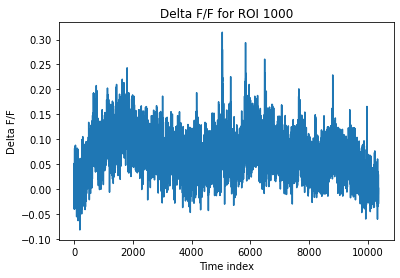

In [15]:
plt.plot(dff[:, ex_roi_index])
plt.title('Delta F/F for ROI ' + str(ex_roi_index))
plt.ylabel('Delta F/F')
plt.xlabel('Time index')

## Now we apply various criteria to get the list of events we analyze

In [16]:
# Load the raw annotations
annotations = read_full_annotations(ps['annotation_file'])

# Mark quiet periods
quiet_annotations = find_quiet_periods(annots=annotations, 
                                       q_th=ps['q_th'], 
                                       q_start_offset=ps['q_start_offset'],
                                       q_end_offset=ps['q_end_offset'])
    
# Add the marked quiet periods to events in the raw annotations
annotations = pd.concat([annotations, quiet_annotations], ignore_index=True)

# Filter down to "clean" events
annotations = get_basic_clean_annotations_from_full(annotations, clean_def=ps['clean_event_def'])

# Apply the cut off time threshold
annotations = apply_cutoff_times(annots=annotations, co_th=ps['co_th'])

# Filter events by the behavior transitioned into or from if we are suppose to
if ps['acc_behs'] is not None:
    keep_inds = [i for i in annotations.index if annotations['beh'][i] in ps['acc_behs']]
    annotations = annotations.loc[keep_inds]

if ps['acc_pre_behs'] is not None:
    keep_inds = [i for i in annotations.index if annotations['beh_before'][i] in ps['acc_pre_behs']]
    annotations = annotations.loc[keep_inds]
    
# Pool preceeding turns if requested
if ps['pool_preceeding_turns']:
    turn_rows = (annotations['beh_before'] == 'TL') | (annotations['beh_before'] == 'TR')
    annotations.loc[turn_rows, 'beh_before'] = 'TC'
 
# Pool succeeding turns if requested
if ps['pool_succeeding_turns']:
    turn_rows = (annotations['beh'] == 'TL') | (annotations['beh'] == 'TR')
    annotations.loc[turn_rows, 'beh'] = 'TC'

if ps['remove_st']:
    self_trans = annotations['beh_before'] == annotations['beh']
    annotations = annotations.loc[~self_trans]


## Display table of filtered-down event annotations

In [17]:
annotations

,start,end,beh,beh_before,beh_before_start,beh_before_end,beh_after,beh_after_start,beh_after_end
3,13,22,TC,H,11,12,B,23,33
8,59,62,TC,F,51,57,H,63,69
19,149,167,F,F,134,150,P,168,174
35,324,327,TC,F,306,324,TL,330,338
36,330,338,TC,TC,324,327,H,340,342
...,...,...,...,...,...,...,...,...,...
536,8927,9088,Q,F,8911,8924,TR,9091,9095
538,9451,9481,Q,F,9427,9448,P,9484,9493
541,10062,10079,Q,H,10052,10059,P,10082,10089
542,10105,10125,Q,F,10090,10102,P,10128,10136


## Plot DFF for an example ROI with start and end of each event marked (in green and red respectively)

Text(0.5, 0, 'Time index')

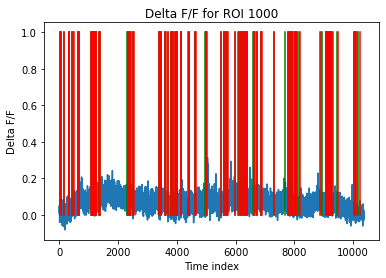

In [18]:
plt.plot(dff[:, ex_roi_index])

for start in annotations['start']:
    plt.plot([start, start], [0, 1], 'g-')

for start in annotations['end']:
    plt.plot([start, start], [0, 1], 'r-')
    
plt.title('Delta F/F for ROI ' + str(ex_roi_index))
plt.ylabel('Delta F/F')
plt.xlabel('Time index')